## Exploratory Data Analysis

In [1]:
import os
import pandas as pd
# Load the dataset
data_dir = "cell_images"
infected_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")
infected_files = os.listdir(infected_dir)
uninfected_files = os.listdir(uninfected_dir)
directories = ['Uninfected', 'Parasitized']

# Create a dataframe containing the file paths and labels
df1 = pd.DataFrame({
    "file_path": [os.path.join(infected_dir, file) for file in infected_files] + [os.path.join(uninfected_dir, file) for file in uninfected_files],
    "label": ["Parasitized" for _ in infected_files] + ["Uninfected" for _ in uninfected_files]
})


In [2]:
df1.count()

file_path    27558
label        27558
dtype: int64

Parasitized    13779
Uninfected     13779
Name: label, dtype: int64


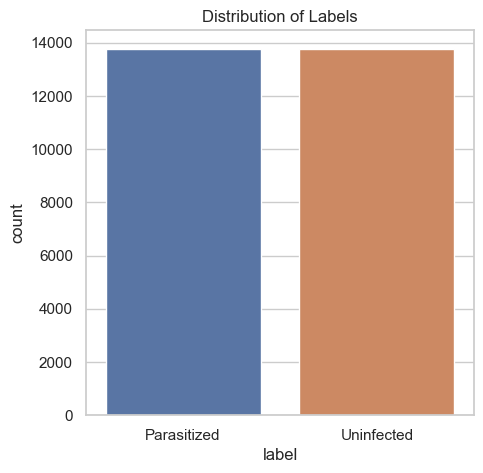

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of files for each label
count_by_label = df1["label"].value_counts()
print(count_by_label)

# Plot the distribution of labels
plt.figure(figsize=(5,5))
sns.set_theme(style="whitegrid")
sns.countplot(x="label", data=df1)
plt.title("Distribution of Labels")
plt.show( )

## Preperation and Preprocessing

In [4]:
import cv2 # computer vision package we've used before
import numpy as np

# Loop through the label subdirectories and collect the data in two lists, 
# one list for labels themselves and one list for the images inside those label folders.
data=[]
for labels in directories:
    path = os.path.join(data_dir, labels)
    class_num = directories.index(labels)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        new_array = cv2.resize(img_array, (64, 64))
        data.append([new_array, class_num])

In [5]:
from keras.utils import np_utils

#append feature and label
X = []
y = []

for feature, label in data:
    X.append(feature)
    y.append(label)
    
#converting to categorical for one hot encoding
num_classes = 2
y = np_utils.to_categorical(y, num_classes = num_classes )


#Reshaping data to rgb
X = np.array(X)
y = np.array(y)

X = X.reshape(-1, 64, 64, 3)

In [6]:
from sklearn.model_selection import train_test_split

#data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

#data augmentation
train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

## Build, Train and Evaluate Model

### VGG16

In [8]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model

vg16 = VGG16(input_shape=[64, 64] + [3], weights="imagenet", include_top=False)

for layer in vg16.layers:
    layer.trainable = False

# Add new layers to the model
x = Flatten()(vg16.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
prediction = Dense(len(directories), activation="softmax")(x)

model = Model(inputs=vg16.input, outputs=prediction)

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch = len(X_train)/64,
                    epochs = 15,
                    shuffle = False,
                    validation_data=test_generator, validation_steps=len(test_generator))

Epoch 1/15
301/301 [==============================] - 40s 102ms/step - loss: 0.3758 - accuracy: 0.8302 - val_loss: 0.2458 - val_accuracy: 0.9032
Epoch 2/15
301/301 [==============================] - 27s 91ms/step - loss: 0.3188 - accuracy: 0.8678 - val_loss: 0.2253 - val_accuracy: 0.9156
Epoch 3/15
301/301 [==============================] - 27s 90ms/step - loss: 0.3072 - accuracy: 0.8724 - val_loss: 0.2201 - val_accuracy: 0.9172
Epoch 4/15
301/301 [==============================] - 27s 90ms/step - loss: 0.2995 - accuracy: 0.8763 - val_loss: 0.2449 - val_accuracy: 0.8989
Epoch 5/15
301/301 [==============================] - 27s 91ms/step - loss: 0.2896 - accuracy: 0.8828 - val_loss: 0.2152 - val_accuracy: 0.9193
Epoch 6/15
301/301 [==============================] - 27s 90ms/step - loss: 0.2856 - accuracy: 0.8836 - val_loss: 0.2038 - val_accuracy: 0.9227
Epoch 7/15
301/301 [==============================] - 27s 91ms/step - loss: 0.2791 - accuracy: 0.8875 - val_loss: 0.2295 - val_accuracy

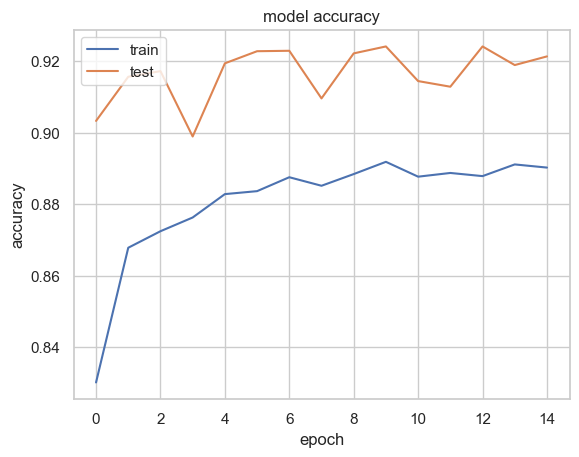

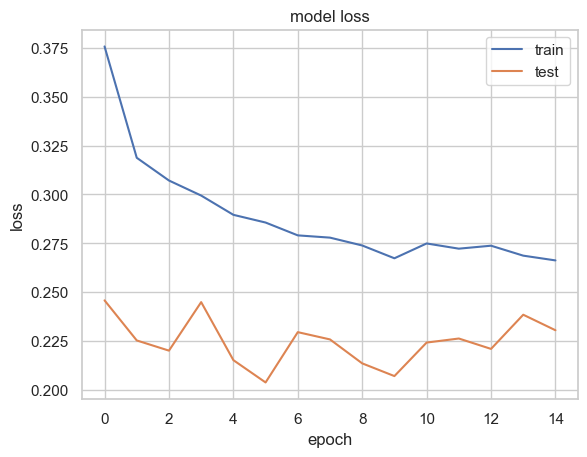

In [10]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=directories))

259/259 [==============================] - 9s 34ms/step
              precision    recall  f1-score   support

  Uninfected       0.97      0.65      0.78      4146
 Parasitized       0.74      0.98      0.84      4122

    accuracy                           0.82      8268
   macro avg       0.85      0.82      0.81      8268
weighted avg       0.86      0.82      0.81      8268



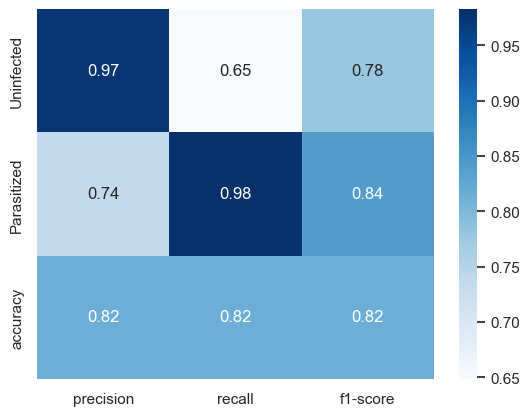

In [12]:
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=directories, output_dict=True)

# Convert report to a dataframe
df = pd.DataFrame(report).transpose()

# Generate heatmap
sns.heatmap(df.drop(['macro avg', 'weighted avg'], axis=0).iloc[:, :3], annot=True, cmap='Blues')

# Show the plot
plt.show()

259/259 [==============================] - 9s 34ms/step


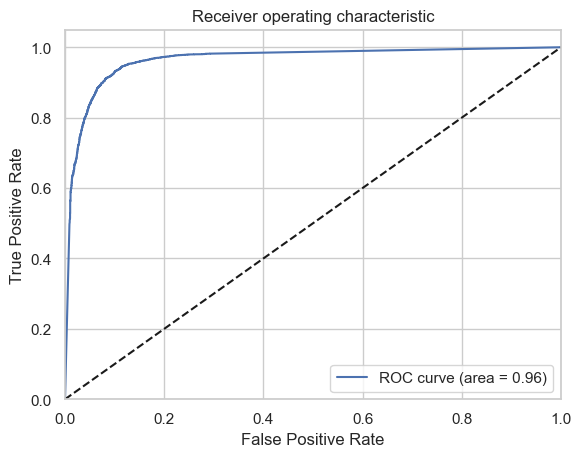

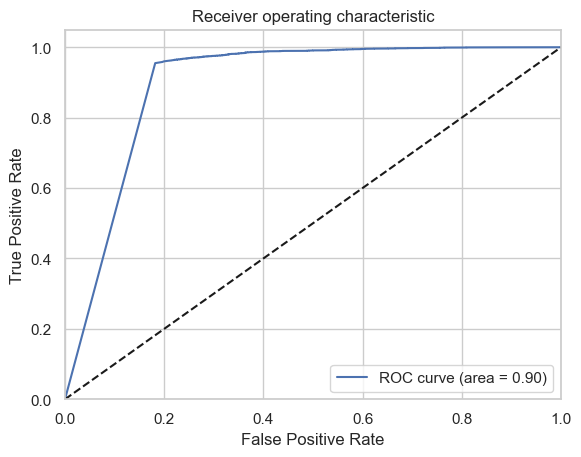

In [15]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) # get the prediction probabilities
num_classes = 2 # number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### EfficientNetB7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Build the EfficientNetB7 model
base_model_ENB7 = EfficientNetB7(weights="imagenet", include_top=False, input_shape=[64, 64] + [3])
x1 = base_model_ENB7.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(256, activation="relu")(x1)
predictions = Dense(num_classes, activation="softmax")(x1)
model1 = Model(inputs=base_model_ENB7.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model_ENB7.layers:
    layer.trainable = False

# Compile the model
model1.compile(optimizer=Adam(lr=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Print the model summary
model1.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_10 (Rescaling)       (None, 64, 64, 3)    0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 64, 64, 3)   7           ['rescaling_10[0][0]']           
 )                                                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 64, 64, 3)    0           ['normalization_5[0][0]']  

c:\Users\gauta\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 16, 16, 192)  1728       ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 16, 16, 192)  768        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 16, 16, 192)  0          ['block2a_bn[0][0]']             
 )                                                                                                
          

In [ ]:
history1 = model1.fit(train_generator,
                    steps_per_epoch = len(X_train)/64,
                    epochs = 10,
                    shuffle = False,
                    validation_data=(X_test, y_test), validation_steps=len(test_generator))


Epoch 1/10
301/301 [==============================] - 120s 330ms/step - loss: 0.6995 - accuracy: 0.4989 - val_loss: 0.6936 - val_accuracy: 0.5010
Epoch 2/10
301/301 [==============================] - 94s 313ms/step - loss: 0.6937 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.5481
Epoch 3/10
301/301 [==============================] - 94s 313ms/step - loss: 0.6934 - accuracy: 0.4994 - val_loss: 0.6934 - val_accuracy: 0.4985
Epoch 4/10
301/301 [==============================] - 94s 312ms/step - loss: 0.6934 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 5/10
301/301 [==============================] - 94s 312ms/step - loss: 0.6933 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4963
Epoch 6/10
301/301 [==============================] - 94s 312ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6940 - val_accuracy: 0.4118
Epoch 7/10
301/301 [==============================] - 94s 312ms/step - loss: 0.6934 - accuracy: 0.4964 - val_loss: 0.6932 - val_a

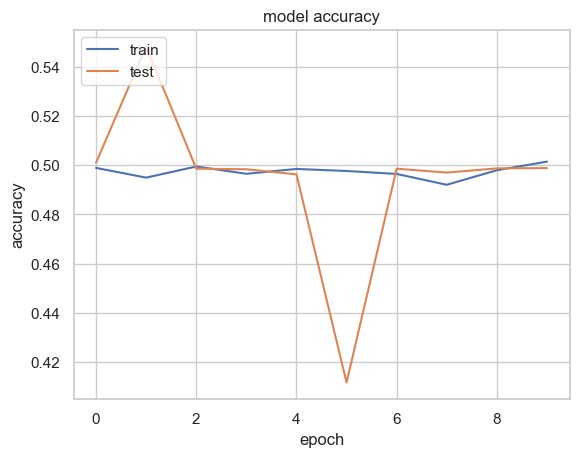

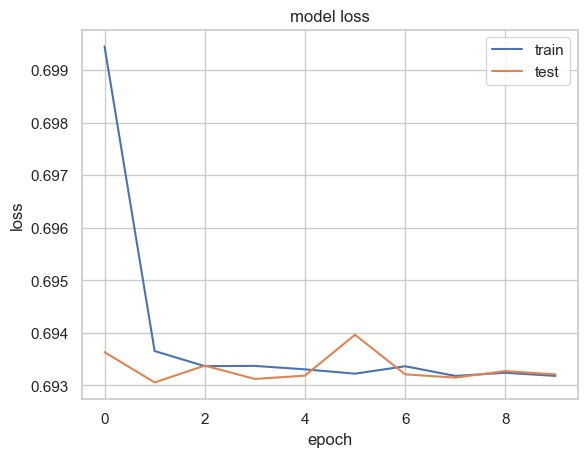

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=directories))

              precision    recall  f1-score   support

  Uninfected       1.00      0.00      0.00      4146
 Parasitized       0.50      1.00      0.67      4122

    accuracy                           0.50      8268
   macro avg       0.75      0.50      0.33      8268
weighted avg       0.75      0.50      0.33      8268



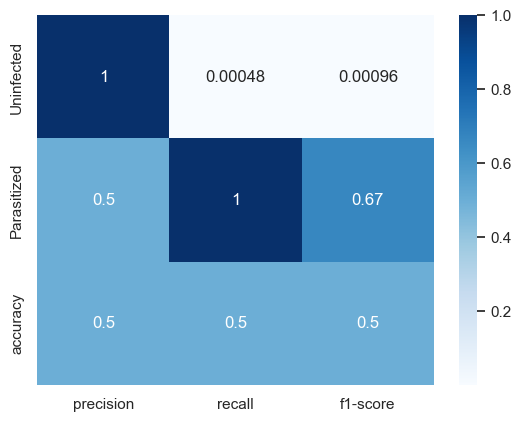

In [ ]:
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=directories, output_dict=True)

# Convert report to a dataframe
df = pd.DataFrame(report).transpose()

# Generate heatmap
sns.heatmap(df.drop(['macro avg', 'weighted avg'], axis=0).iloc[:, :3], annot=True, cmap='Blues')

# Show the plot
plt.show()

259/259 [==============================] - 33s 125ms/step


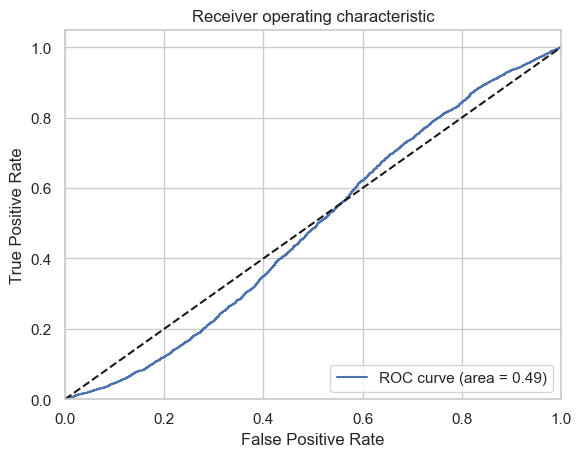

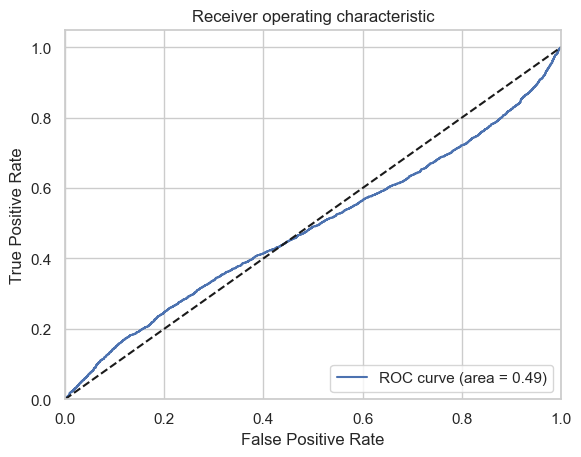

In [ ]:
from sklearn.metrics import roc_curve, auc

y_score = y_pred # get the prediction probabilities
 # number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### CNN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten

# Create the model
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64, 64, 3), 
                 activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3))
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.4))
model2.add(Dense(num_classes, activation='softmax')) # num_classes = 8

# Compile model
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
print(model2.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 28800)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               14746112  
                                                        

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=4)
epochs = 40
seed = 1234
np.random.seed(seed)
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


print(len(history.history['loss']))

Epoch 1/40
1206/1206 [==============================] - 26s 20ms/step - loss: 10.4715 - accuracy: 0.5500 - val_loss: 2.5409 - val_accuracy: 0.5772
Epoch 2/40
1206/1206 [==============================] - 24s 20ms/step - loss: 1.7966 - accuracy: 0.5785 - val_loss: 1.3114 - val_accuracy: 0.5949
Epoch 3/40
1206/1206 [==============================] - 24s 20ms/step - loss: 1.1923 - accuracy: 0.5882 - val_loss: 1.0301 - val_accuracy: 0.5665
Epoch 4/40
1206/1206 [==============================] - 24s 20ms/step - loss: 1.0543 - accuracy: 0.5947 - val_loss: 1.0232 - val_accuracy: 0.5510
Epoch 5/40
1206/1206 [==============================] - 24s 20ms/step - loss: 0.9305 - accuracy: 0.5992 - val_loss: 0.8796 - val_accuracy: 0.6032
Epoch 6/40
1206/1206 [==============================] - 24s 20ms/step - loss: 0.9171 - accuracy: 0.6059 - val_loss: 0.8343 - val_accuracy: 0.6193
Epoch 7/40
1206/1206 [==============================] - 24s 20ms/step - loss: 0.8220 - accuracy: 0.6089 - val_loss: 0.7743 

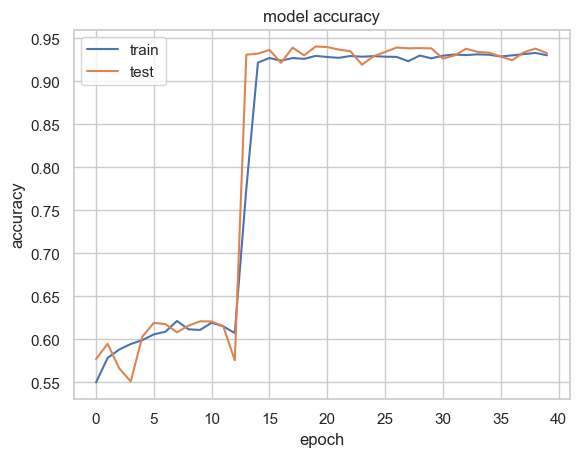

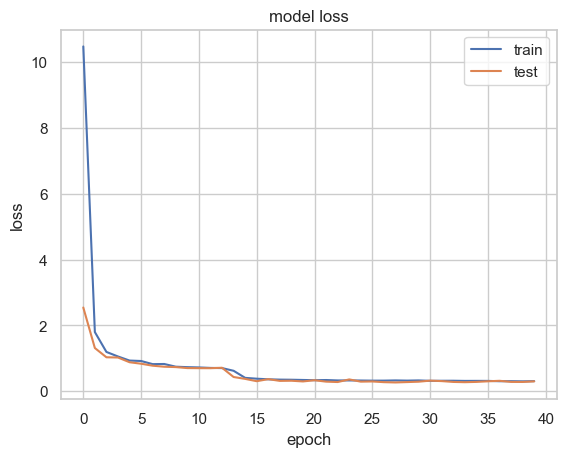

In [20]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [24]:
from sklearn.metrics import classification_report

y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=directories))

259/259 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

  Uninfected       0.95      0.92      0.93      4146
 Parasitized       0.92      0.95      0.93      4122

    accuracy                           0.93      8268
   macro avg       0.93      0.93      0.93      8268
weighted avg       0.93      0.93      0.93      8268



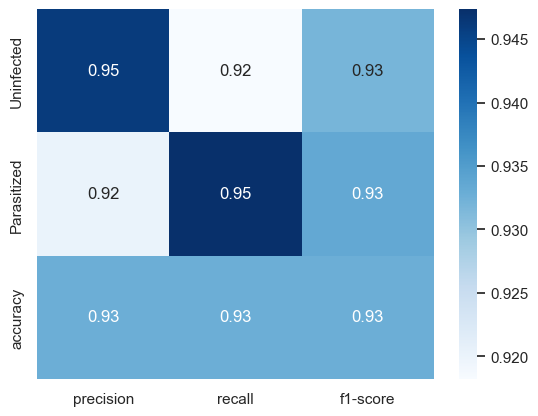

In [22]:
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=directories, output_dict=True)

# Convert report to a dataframe
df = pd.DataFrame(report).transpose()

# Generate heatmap
sns.heatmap(df.drop(['macro avg', 'weighted avg'], axis=0).iloc[:, :3], annot=True, cmap='Blues')

# Show the plot
plt.show()

259/259 [==============================] - 1s 5ms/step


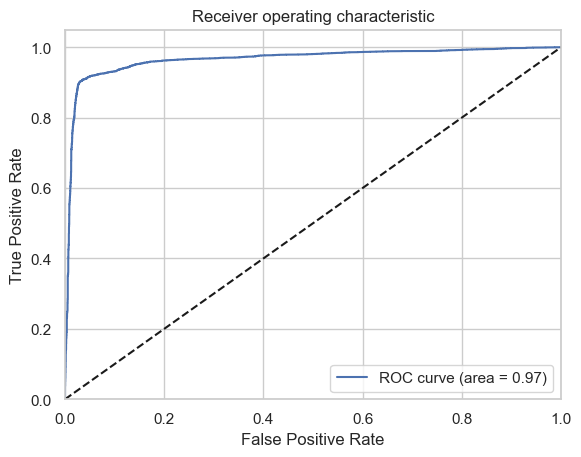

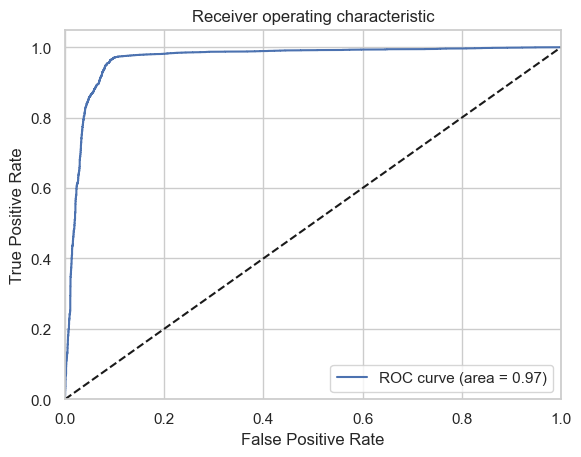

In [25]:
from sklearn.metrics import roc_curve, auc

y_score = model2.predict(X_test) # get the prediction probabilities
 # number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')  
    plt.legend(loc="lower right")
    plt.show()

#### Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

# Step 1: build the model and compile it with the parametrs you want to optimise and search through using: 
# hp.choice('units', [8,16,32])

def build_model(hp):
    # Create the model
    model = Sequential()
    model.add(Conv2D(hp.Choice('filters', [16, 32, 64]), 
                     kernel_size=(3,3), 
                     input_shape=(64, 64, 3), 
                     activation='relu', 
                     kernel_regularizer=l2(hp.Choice('l2_reg', [0.01, 0.001]))))
    model.add(Dropout(hp.Choice('dropout_rate', [0.3, 0.4])))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     activation='relu', 
                     kernel_regularizer=l2(hp.Choice('l2_reg', [0.01, 0.001]))))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_units', [512, 1024]), activation='relu', 
                    kernel_regularizer=l2(hp.Choice('l2_reg', [0.01, 0.001]))))
    model.add(Dropout(hp.Choice('dropout_rate', [0.3, 0.4])))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




In [ ]:
# Step 2: use RandomSearch from keras_tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [ ]:
# Step 3: start the search
tuner.search(X_train, y_train, epochs=25, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 08m 50s]
val_loss: 1.079538106918335

Best val_loss So Far: 0.3074723780155182
Total elapsed time: 00h 29m 51s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
filters: 32
l2_reg: 0.01
dropout_rate: 0.4
dense_units: 1024
Score: 0.3074723780155182

Trial 1 summary
Hyperparameters:
filters: 32
l2_reg: 0.01
dropout_rate: 0.3
dense_units: 512
Score: 0.7009240984916687

Trial 3 summary
Hyperparameters:
filters: 32
l2_reg: 0.01
dropout_rate: 0.4
dense_units: 512
Score: 0.7108293175697327

Trial 4 summary
Hyperparameters:
filters: 32
l2_reg: 0.001
dropout_rate: 0.3
dense_units: 1024
Score: 1.079538106918335

Trial 2 summary
Hyperparameters:
filters: 16
l2_reg: 0.01
dropout_rate: 0.4
dense_units: 512
Traceback (most recent call last):
  File "c:\Users\gauta\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\gauta\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", li

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 1024)              29492224  
                                                        